# Triangulation
Useful links:
- [ ] https://www.youtube.com/watch?v=UZlRhEUWSas
- [ ] https://en.wikipedia.org/wiki/Triangulation_(computer_vision)
- [ ] https://gist.github.com/cr333/0d0e6c256f93c0ed7bd2
- [ ] https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/autonomous-vision/lectures/computer-vision/
- [ ] https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html
- [ ] https://www.changjiangcai.com/files/text-books/Richard_Hartley_Andrew_Zisserman-Multiple_View_Geometry_in_Computer_Vision-EN.pdf
- [ ] https://medium.com/@insight-in-plain-sight/estimating-the-homography-matrix-with-the-direct-linear-transform-dlt-ec6bbb82ee2b
- [ ] https://glowingpython.blogspot.com/2011/06/svd-decomposition-with-numpy.html

In [1]:
pip install opencv-python numpy scipy matplotlib pandas tabulate

Note: you may need to restart the kernel to use updated packages.


In [25]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import src.hz_triangulation
from src.hz_triangulation import HZTriangulation
from src.calibrator import Calibrator
# from src.calibrator import additional_points
import importlib  # importlib is a module from the standard library
import src.utils as utils

np.set_printoptions(precision=5, suppress=True)
importlib.reload(src.hz_triangulation)
importlib.reload(src.utils)

<module 'src.utils' from '/home/jovyan/repos/github.com/triangulation/src/utils.py'>

In [15]:
frame_size = (3648, 2736)

index_first = 2
index_second = 3

calibrator = Calibrator('assets/calibration_new/', 'img-*.jpg',
                        frameSize=frame_size, chessboardSize=(7, 5), chessboard_square_mm=29.15)
calibrator.calibrate()

True
True
True
True
True
True
True
True
True
True

Camera calibrated:  0.4178394466041533
Camera Matrix:  [[2790.294373778    0.          1827.29216617 ]
 [   0.          2794.318007802 1402.015521139]
 [   0.             0.             1.         ]]
Distortion Parameters:  [[ 0.27683505  -2.987342069  0.000200696  0.000459854  6.71839633 ]]
Rotation Vectors:  (array([[-0.741706647],
       [-0.008120225],
       [-0.182648646]]), array([[-0.502829282],
       [ 0.020669438],
       [-0.270155395]]), array([[-0.761454366],
       [ 0.475764108],
       [ 1.298924242]]), array([[-0.481109249],
       [ 0.147693592],
       [ 0.626032156]]), array([[-0.205764957],
       [ 0.42302761 ],
       [ 1.380929914]]), array([[-0.38922491 ],
       [ 0.516165039],
       [ 1.495358733]]), array([[-0.689999998],
       [-0.0743859  ],
       [-0.096006657]]), array([[-0.631370067],
       [ 0.225574234],
       [ 0.904118162]]), array([[-0.316729012],
       [ 0.553199823],
       [ 1.602964386]]

P for img-*.jpg, index: 2
[[   -650.16435   -3128.4945      956.31995 1717675.64403]
 [    906.04202     -92.98388    2990.70268  695757.29531]
 [     -0.70124      -0.23232       0.67401     843.00083]]
P for img-*.jpg, index: 3
[[   1740.97496   -2366.42416    1579.17138 1763360.73509]
 [   1087.61009    1426.29795    2560.5935   846550.68935]
 [     -0.27499      -0.38722       0.88002    1034.11411]]
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)
(2736, 3648, 3)


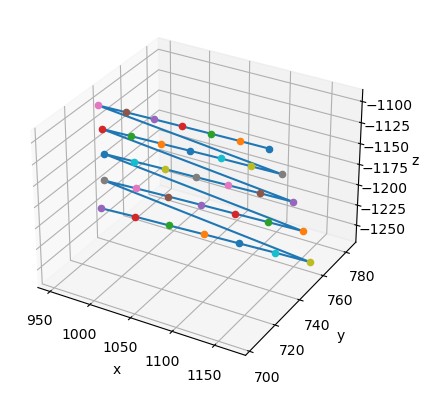

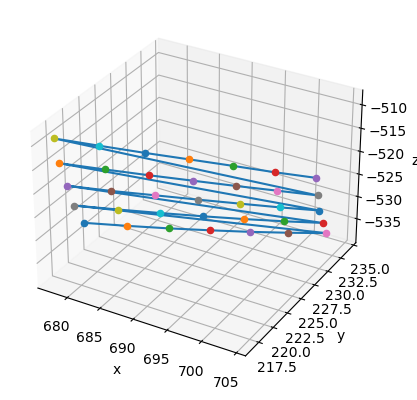

          X (1)       Y (1)        Z (1)  Tiefe C1 (1)  Tiefe C2 (1)       X (2)       Y (2)       Z (2)  Tiefe C1 (2)  Tiefe C2 (2)
0   1084.466743  783.090353 -1175.884073    981.346145    789.913648  680.265442  217.884125 -526.987732    107.984863    483.806160
1   1060.626971  774.432394 -1161.908656    956.926324    760.970093  684.513611  220.221237 -528.489807    107.664482    483.630821
2   1037.560862  765.956624 -1148.459714    933.549541    732.968456  688.541260  222.685257 -530.133545    107.662286    483.231774
3   1014.973954  757.674821 -1135.276787    910.911178    705.549142  692.401794  225.313034 -531.912170    107.945758    482.615802
4    993.163149  749.656407 -1122.562222    889.307426    679.073133  696.061646  228.075821 -533.863525    108.559051    481.760231
5    971.712653  741.724667 -1110.091003    868.325639    653.035783  699.515198  231.024323 -535.978760    109.468554    480.634456
6    950.552437  733.865738 -1097.813357    847.903831    627.351760 

In [27]:
def triangulate_and_evaluate(index_first, index_second, calibrator, out_dir, verbose=False):
    K_1, _ = calibrator.calculateProjection(index_first)
    K_2, _ = calibrator.calculateProjection(index_second)

    img1 = cv.imread('assets/calibration_new/img-%02d.jpg' % (index_first+1))
    img2 = cv.imread('assets/calibration_new/img-%02d.jpg' % (index_second+1))

    p1 = calibrator.imgpoints_as_int(index_first)
    # p1 = np.concatenate((p1, additional_points[index_first]))
    p2 = calibrator.imgpoints_as_int(index_second)
    # p2 = np.concatenate((p2, additional_points[index_second]))
    if verbose:
        print(p1.shape, p2.shape, K_1.shape, K_2.shape)

    hz = HZTriangulation(img1, img2, p1, p2, K_1, K_2)
    if verbose:
        print('F:\n{hz.F}\n'.format(**locals()))
    hz.save_with_markers('%s/base-with-markers-%02i-%02i.jpg' %
                         (out_dir, index_first, index_second))

    points_hz = hz.triangulate()
    if verbose:
        print(points_hz)

    # triangulate points with opencv's method for comparison
    points_cv = hz.triangulateOpenCv()
    if verbose:
        print(points_cv)

    utils.plot_3d(points_hz, out_file='%s/3d-triangulated-hz-%02i-%02i.jpg' %
                        (out_dir, index_first, index_second))
    utils.plot_3d(points_cv, out_file='%s/3d-triangulated-cv-%02i-%02i.jpg' %
                        (out_dir, index_first, index_second))

    # Calculate Camera Center
    C = utils.camera_center(K_1)
    C_1 = utils.camera_center_inhomogen(K_1)
    C_2 = utils.camera_center_inhomogen(K_2)
    if verbose:
        print(C)
        print(K_1.dot(C))  # check if close to 0

    utils.evaluate_points((points_hz, points_cv), (C_1, C_2), calibrator.chessboardSize,
                          calibrator.size_of_chessboard_squares_mm, out_file='%s/evaluation-%02i-%02i' % (out_dir, index_first, index_second))

triangulate_and_evaluate(index_first, index_second,
                         calibrator, 'assets/generated')